In [19]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.1+cu121


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [21]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_gnn_dataset import SolutionDataset

dataset = SolutionDataset(root='../../data/raw')

In [22]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')



Dataset: SolutionDataset(50000):
Number of graphs: 50000
Number of features: 139


In [23]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [24]:
x1, y1 = printstats(0)
x2, y2 = printstats(-1)


Data(edge_index=[2, 165], name=[166], cooccurrences=[166, 139], num_nodes=166, x=[166, 139], y=[100])
Number of nodes: 166
Number of edges: 165
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
Data.y: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[0].y.size(-1)

print(NODE_FEATURES)
print(NUM_CLASSES)


139
100


In [26]:
assert (len(dataset) % 10 == 0)
split = (len(dataset) * 9) // 10

train_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 != 0]
test_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 == 0]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 45000
Number of test graphs: 5000


In [27]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    data = data.to(device)
    
    if (step) % 2500 == 0:
        print(f'Step {step}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

Step 0:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 179], name=[1], cooccurrences=[180, 139], num_nodes=180, x=[180, 139], y=[100], batch=[180], ptr=[2])

Step 2500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 96], name=[1], cooccurrences=[97, 139], num_nodes=97, x=[97, 139], y=[100], batch=[97], ptr=[2])

Step 5000:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 134], name=[1], cooccurrences=[135, 139], num_nodes=135, x=[135, 139], y=[100], batch=[135], ptr=[2])

Step 7500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 302], name=[1], cooccurrences=[303, 139], num_nodes=303, x=[303, 139], y=[100], batch=[303], ptr=[2])

Step 10000:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 133], name=[1], cooccurrences=[134, 139], num_nodes=134, x=[134, 139], y=[100], batch=[134], ptr=[2])

Step 12500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 219], name=[1], cooccurrences

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [28]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class BaseNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BaseNN, self).__init__()
        # self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.lin1 = Linear(NODE_FEATURES, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.linout = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, batch):
        # x = self.conv1(x, edge_index)

        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x,)
        x = x.relu()

        x = global_mean_pool(x, batch)  
        
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.linout(x)
        return x


model = BaseNN(hidden_channels=512).to(device) 
print(model)

BaseNN(
  (lin1): Linear(in_features=139, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=512, bias=True)
  (linout): Linear(in_features=512, out_features=100, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [29]:
EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}
epoch_accuracies = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Progress"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.batch)
        yTrue = batch.y.float().reshape(1, NUM_CLASSES)
        loss = criterion(out, yTrue)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        max_idx = torch.argmax(out)
        predicted = torch.zeros_like(out)
        predicted[0][max_idx] = 1
        correct += 1 if (torch.equal(predicted, batch.y.float().reshape(1, NUM_CLASSES))) else 0
        total += 1
    
    epoch_accuracy = correct / total
    epoch_losses[epoch + 1] = epoch_loss
    epoch_accuracies[epoch + 1] = epoch_accuracy
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Correct: {correct}, Total: {total}, Accuracy: {epoch_accuracy:.4f}")

print("Training completed.")


Epoch 1/50 Progress: 100%|██████████| 45000/45000 [02:20<00:00, 319.65it/s]


Epoch 1/50, Loss: 78206.1444, Correct: 24140, Total: 45000, Accuracy: 0.5364


Epoch 2/50 Progress: 100%|██████████| 45000/45000 [02:18<00:00, 324.10it/s]


Epoch 2/50, Loss: 33367.5530, Correct: 35594, Total: 45000, Accuracy: 0.7910


Epoch 3/50 Progress: 100%|██████████| 45000/45000 [01:40<00:00, 446.66it/s]


Epoch 3/50, Loss: 24869.0617, Correct: 37955, Total: 45000, Accuracy: 0.8434


Epoch 4/50 Progress: 100%|██████████| 45000/45000 [01:39<00:00, 451.61it/s]


Epoch 4/50, Loss: 21318.0823, Correct: 38969, Total: 45000, Accuracy: 0.8660


Epoch 5/50 Progress: 100%|██████████| 45000/45000 [01:40<00:00, 447.41it/s]


Epoch 5/50, Loss: 19380.7541, Correct: 39428, Total: 45000, Accuracy: 0.8762


Epoch 6/50 Progress: 100%|██████████| 45000/45000 [01:41<00:00, 443.32it/s]


Epoch 6/50, Loss: 18158.9206, Correct: 39722, Total: 45000, Accuracy: 0.8827


Epoch 7/50 Progress: 100%|██████████| 45000/45000 [01:40<00:00, 446.76it/s]


Epoch 7/50, Loss: 17281.3987, Correct: 39967, Total: 45000, Accuracy: 0.8882


Epoch 8/50 Progress: 100%|██████████| 45000/45000 [01:41<00:00, 444.41it/s]


Epoch 8/50, Loss: 16605.1602, Correct: 40108, Total: 45000, Accuracy: 0.8913


Epoch 9/50 Progress: 100%|██████████| 45000/45000 [01:41<00:00, 443.86it/s]


Epoch 9/50, Loss: 16074.7585, Correct: 40294, Total: 45000, Accuracy: 0.8954


Epoch 10/50 Progress: 100%|██████████| 45000/45000 [01:40<00:00, 447.75it/s]


Epoch 10/50, Loss: 15714.6557, Correct: 40420, Total: 45000, Accuracy: 0.8982


Epoch 11/50 Progress: 100%|██████████| 45000/45000 [01:40<00:00, 447.14it/s]


Epoch 11/50, Loss: 15277.5596, Correct: 40475, Total: 45000, Accuracy: 0.8994


Epoch 12/50 Progress: 100%|██████████| 45000/45000 [01:44<00:00, 431.52it/s]


Epoch 12/50, Loss: 14929.2622, Correct: 40582, Total: 45000, Accuracy: 0.9018


Epoch 13/50 Progress: 100%|██████████| 45000/45000 [02:20<00:00, 321.42it/s]


Epoch 13/50, Loss: 14732.7668, Correct: 40706, Total: 45000, Accuracy: 0.9046


Epoch 14/50 Progress: 100%|██████████| 45000/45000 [02:23<00:00, 312.93it/s]


Epoch 14/50, Loss: 14393.0317, Correct: 40723, Total: 45000, Accuracy: 0.9050


Epoch 15/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 311.81it/s]


Epoch 15/50, Loss: 14210.0313, Correct: 40813, Total: 45000, Accuracy: 0.9070


Epoch 16/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.56it/s]


Epoch 16/50, Loss: 13977.2531, Correct: 40829, Total: 45000, Accuracy: 0.9073


Epoch 17/50 Progress: 100%|██████████| 45000/45000 [02:23<00:00, 312.59it/s]


Epoch 17/50, Loss: 13741.0241, Correct: 40965, Total: 45000, Accuracy: 0.9103


Epoch 18/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 311.20it/s]


Epoch 18/50, Loss: 13648.5048, Correct: 40995, Total: 45000, Accuracy: 0.9110


Epoch 19/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 311.76it/s]


Epoch 19/50, Loss: 13483.0982, Correct: 41000, Total: 45000, Accuracy: 0.9111


Epoch 20/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.64it/s]


Epoch 20/50, Loss: 13382.5940, Correct: 40987, Total: 45000, Accuracy: 0.9108


Epoch 21/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 311.94it/s]


Epoch 21/50, Loss: 13311.2574, Correct: 41046, Total: 45000, Accuracy: 0.9121


Epoch 22/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 311.66it/s]


Epoch 22/50, Loss: 13127.6915, Correct: 41100, Total: 45000, Accuracy: 0.9133


Epoch 23/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.70it/s]


Epoch 23/50, Loss: 13087.6261, Correct: 41048, Total: 45000, Accuracy: 0.9122


Epoch 24/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.36it/s]


Epoch 24/50, Loss: 12978.7301, Correct: 41128, Total: 45000, Accuracy: 0.9140


Epoch 25/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.01it/s]


Epoch 25/50, Loss: 12819.3969, Correct: 41202, Total: 45000, Accuracy: 0.9156


Epoch 26/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.67it/s]


Epoch 26/50, Loss: 12810.8902, Correct: 41119, Total: 45000, Accuracy: 0.9138


Epoch 27/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.18it/s]


Epoch 27/50, Loss: 12725.5160, Correct: 41152, Total: 45000, Accuracy: 0.9145


Epoch 28/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.97it/s]


Epoch 28/50, Loss: 12656.1059, Correct: 41167, Total: 45000, Accuracy: 0.9148


Epoch 29/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.23it/s]


Epoch 29/50, Loss: 12552.6734, Correct: 41172, Total: 45000, Accuracy: 0.9149


Epoch 30/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.42it/s]


Epoch 30/50, Loss: 12472.8453, Correct: 41244, Total: 45000, Accuracy: 0.9165


Epoch 31/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.07it/s]


Epoch 31/50, Loss: 12494.6810, Correct: 41248, Total: 45000, Accuracy: 0.9166


Epoch 32/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 308.77it/s]


Epoch 32/50, Loss: 12434.0114, Correct: 41298, Total: 45000, Accuracy: 0.9177


Epoch 33/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.22it/s]


Epoch 33/50, Loss: 12304.0178, Correct: 41314, Total: 45000, Accuracy: 0.9181


Epoch 34/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.93it/s]


Epoch 34/50, Loss: 12302.9666, Correct: 41327, Total: 45000, Accuracy: 0.9184


Epoch 35/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 312.20it/s]


Epoch 35/50, Loss: 12246.6967, Correct: 41319, Total: 45000, Accuracy: 0.9182


Epoch 36/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 308.56it/s]


Epoch 36/50, Loss: 12147.5721, Correct: 41306, Total: 45000, Accuracy: 0.9179


Epoch 37/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.23it/s]


Epoch 37/50, Loss: 12140.1623, Correct: 41295, Total: 45000, Accuracy: 0.9177


Epoch 38/50 Progress: 100%|██████████| 45000/45000 [02:26<00:00, 307.88it/s]


Epoch 38/50, Loss: 12063.6609, Correct: 41372, Total: 45000, Accuracy: 0.9194


Epoch 39/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.71it/s]


Epoch 39/50, Loss: 12053.8629, Correct: 41348, Total: 45000, Accuracy: 0.9188


Epoch 40/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.60it/s]


Epoch 40/50, Loss: 12010.2277, Correct: 41419, Total: 45000, Accuracy: 0.9204


Epoch 41/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.66it/s]


Epoch 41/50, Loss: 11929.7796, Correct: 41426, Total: 45000, Accuracy: 0.9206


Epoch 42/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 308.82it/s]


Epoch 42/50, Loss: 11903.1169, Correct: 41341, Total: 45000, Accuracy: 0.9187


Epoch 43/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 310.14it/s]


Epoch 43/50, Loss: 11885.0279, Correct: 41410, Total: 45000, Accuracy: 0.9202


Epoch 44/50 Progress: 100%|██████████| 45000/45000 [02:26<00:00, 307.48it/s]


Epoch 44/50, Loss: 11903.8226, Correct: 41455, Total: 45000, Accuracy: 0.9212


Epoch 45/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.50it/s]


Epoch 45/50, Loss: 11782.0835, Correct: 41416, Total: 45000, Accuracy: 0.9204


Epoch 46/50 Progress: 100%|██████████| 45000/45000 [02:26<00:00, 307.80it/s]


Epoch 46/50, Loss: 11779.4060, Correct: 41442, Total: 45000, Accuracy: 0.9209


Epoch 47/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.70it/s]


Epoch 47/50, Loss: 11761.0380, Correct: 41431, Total: 45000, Accuracy: 0.9207


Epoch 48/50 Progress: 100%|██████████| 45000/45000 [02:25<00:00, 309.57it/s]


Epoch 48/50, Loss: 11758.4292, Correct: 41462, Total: 45000, Accuracy: 0.9214


Epoch 49/50 Progress: 100%|██████████| 45000/45000 [02:24<00:00, 310.90it/s]


Epoch 49/50, Loss: 11735.4988, Correct: 41458, Total: 45000, Accuracy: 0.9213


Epoch 50/50 Progress: 100%|██████████| 45000/45000 [02:26<00:00, 306.72it/s]

Epoch 50/50, Loss: 11716.0617, Correct: 41450, Total: 45000, Accuracy: 0.9211
Training completed.


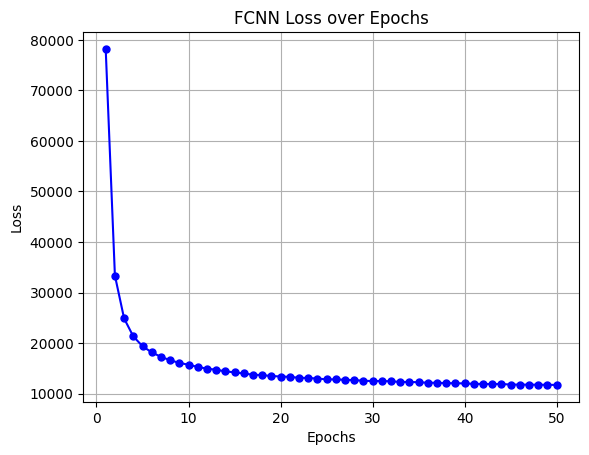

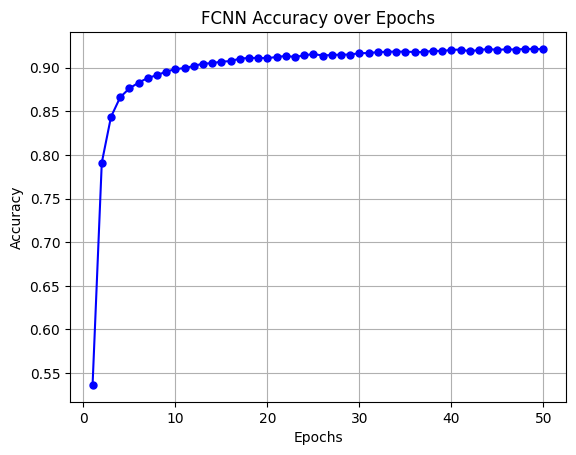

In [43]:
import matplotlib.pyplot as plt

epochs = list(epoch_losses.keys())
losses = list(epoch_losses.values())
accuracies = list(epoch_accuracies.values())

plt.plot(epochs, losses, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FCNN Loss over Epochs')
plt.grid(True)
plt.show()

plt.plot(epochs, accuracies, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FCNN Accuracy over Epochs')
plt.grid(True)
plt.show()

In [31]:
MODEL_PATH = "BaseNNModel_1_standard.pth"

In [32]:
torch.save(model, MODEL_PATH)

In [33]:
loaded_model = torch.load(MODEL_PATH)
loaded_model.eval()

BaseNN(
  (lin1): Linear(in_features=139, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=512, bias=True)
  (linout): Linear(in_features=512, out_features=100, bias=True)
)

Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 530.00it/s]


Top-1 Test Accuracy: 90.64% (4532/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 534.43it/s]


Top-2 Test Accuracy: 96.00% (4800/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 542.48it/s]


Top-3 Test Accuracy: 97.82% (4891/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 527.98it/s]


Top-4 Test Accuracy: 98.32% (4916/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 523.05it/s]


Top-5 Test Accuracy: 98.68% (4934/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 541.73it/s]


Top-6 Test Accuracy: 98.84% (4942/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 544.16it/s]


Top-7 Test Accuracy: 99.04% (4952/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 541.10it/s]


Top-8 Test Accuracy: 99.12% (4956/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 545.01it/s]


Top-9 Test Accuracy: 99.26% (4963/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:09<00:00, 544.11it/s]

Top-10 Test Accuracy: 99.30% (4965/5000)


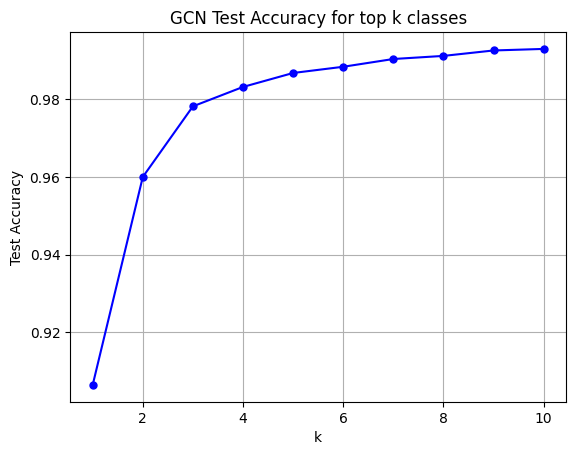

In [35]:
def test(model, test_loader, k=1):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Progress"):
            batch = batch.to(device)
            out = model(batch.x, batch.batch)  # Output shape: (batch_size, num_classes)
            _, topk_indices = torch.topk(out, k, dim=1)  # Get top k class indices
            true_classes = torch.argmax(batch.y.float().reshape(1, NUM_CLASSES), dim=1)  # True class indices
            # Check if true class is among the top k predictions
            correct_batch = (topk_indices == true_classes.unsqueeze(1)).any(dim=1)
            correct += correct_batch.sum().item()
            total += len(true_classes)
        
    return correct, total, correct / total


test_accuracies = {}

# Compute top 10 test accuracies
for k in range(10):
    correct, total, test_accuracy = test(loaded_model, test_loader, k + 1)
    test_accuracies[k + 1] = test_accuracy
    print(f"Top-{k + 1} Test Accuracy: {test_accuracy * 100:.2f}% ({correct}/{total})")

# Plot test accuracies
ks = list(test_accuracies.keys())
test_accuracy_mappings = list(test_accuracies.values())

plt.plot(ks, test_accuracy_mappings, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('GCN Test Accuracy for top k classes')
plt.grid(True)
plt.show()

In [36]:
from sklearn.decomposition import PCA
from constants import *
NUM_SOLUTIONS = 50

def plot_classifications(classes, k, best=False):
    outputs = []
    labels = []
    bottom_k_labels = []
    i = 0

    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    if best:
        sorted_classes = reversed(sorted_classes)

    for c, entry in sorted_classes:
        if i == k:
            break
        bottom_k_labels.append(c)
        for e in entry[1]:
            outputs.append(e)
            labels.append(c)
        i +=1

    # Concatenate all outputs and labels
    outputs = torch.cat(outputs, dim=0)  # Shape: (num_samples, num_classes)

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    outputs_2d = pca.fit_transform(outputs.numpy())  # Shape: (num_samples, 2)

    # Plot the PCA-transformed outputs
    plt.figure(figsize=(12, 8))

    label_to_index = {label: idx for idx, label in enumerate(bottom_k_labels)}
    indices = np.array([label_to_index[label] for label in labels])

    cmap = plt.cm.get_cmap('nipy_spectral', k)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=indices, cmap=cmap, alpha=0.7)

    # Create a legend mapping colors to class labels
    handles = []
    for idx, label in enumerate(bottom_k_labels):
        color = cmap(idx)
        handles.append(plt.Line2D([], [], marker='o', color=color, linestyle='None',
                                markersize=10, label=f'{FILES[label]} ({(classes[label][0] / NUM_SOLUTIONS) * 100:.0f}%)'))
    plt.legend(handles=handles, title='Problems', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add plot titles and labels
    plt.title(f'Top k = {k} most {"accurately" if best else "poorly"} classified problems')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

In [37]:
def plot_problem_accuracies(classes):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])

    problems = []
    accuracies = []
    for c, entry in sorted_classes:
        problems.append(FILES[c])
        accuracies.append(entry[0] / NUM_SOLUTIONS)

    # Create the bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(problems, accuracies, color='skyblue')

    # Add labels and title
    plt.ylabel('Classification accuracy')
    plt.title('Problem classification accuracy')

    plt.xticks(problems, rotation=60, fontsize=7, ha='right')
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    mean_accuracy = sum(accuracies) / len(sorted_classes)
    plt.axhline(y=mean_accuracy, color='red', linestyle='-', linewidth=1)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [41]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# plots the top k classifications for the n worst performing problems
def plot_misclassifications(classes, n=10, k=5):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    
    problems = {}

    i = 0
    for c, entry in sorted_classes:
        if i == n:
            break
        wrong_problems = []

        counts = {}
        for output in entry[1]:
            max_idx = torch.argmax(output).item()
            if max_idx not in counts:
                counts[max_idx] = 0
            counts[max_idx] += 1

        # del counts[c] # delete correct classification
        counts = list(reversed(sorted(counts.items(), key=lambda item: item[1])))
        # counts = counts[:k]

        total = 0
        for count in counts:
            total += count[1]
        
        rem = total
        j = 0
        for idx, count in counts:
            if j == k:
                break
            wrong_problems.append((idx, count / total))
            rem -= count
            j += 1
        
        if rem > 0:
            wrong_problems.append((-1, rem / total))

        problems[c] = wrong_problems
        i += 1

    cmap = cm.get_cmap("autumn")
    categories = {cat for pie in problems.values() for cat, _ in pie}  # Unique categories
    norm = mcolors.Normalize(vmin=0, vmax=len(categories))
    category_to_color = {category: cmap(norm(idx)) for idx, category in enumerate(sorted(categories))}

    num_charts = len(problems)
    cols = 5  # Number of columns
    rows = (num_charts + cols - 1) // cols

    # Create a figure and axes for each pie chart
    _, axes = plt.subplots(rows, cols, figsize=(30, 30), constrained_layout=True)

    axes = axes.flatten()

    # If there's only one chart, make `axes` iterable
    if len(problems) == 1:
        axes = [axes]

    # Loop through the dictionary to create each pie chart
    for ax, (chart_name, categories) in zip(axes, problems.items()):
        # Extract names and percentages
        names, percentages = zip(*categories)

        colors = []
        for name in names:
            if name != chart_name:
                colors.append(category_to_color[name])
            else:
                colors.append('lightgreen')

        names = [FILES[j] if j != -1 else 'other' for j in names]
        
        # Create the pie chart
        wedges, _, autotexts = ax.pie(percentages, startangle=90, radius=1.0, colors=colors, autopct=custom_autopct)
        ax.set_title(FILES[chart_name], fontsize=10)

        # Add a legend mapping colors to names
        ax.legend(wedges, names, loc="center left", bbox_to_anchor=(1, 0.5),
              fontsize='small', markerscale=0.7, labelspacing=0.3)
        
        # Make the percentages smaller
        for autotext in autotexts:
            autotext.set_fontsize(8)  # Set smaller font size for percentages

    # Hide any extra subplot axes
    for ax in axes[num_charts:]:
        ax.axis('off')

    # Adjust layout to prevent overlapping
    plt.suptitle(f'Top classifications for the {n} most poorly classified problems\n')
    plt.show()

def custom_autopct(pct):
    return f"{pct:.1f}%" if pct > 5 else ""



/tmp/ipykernel_6596/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


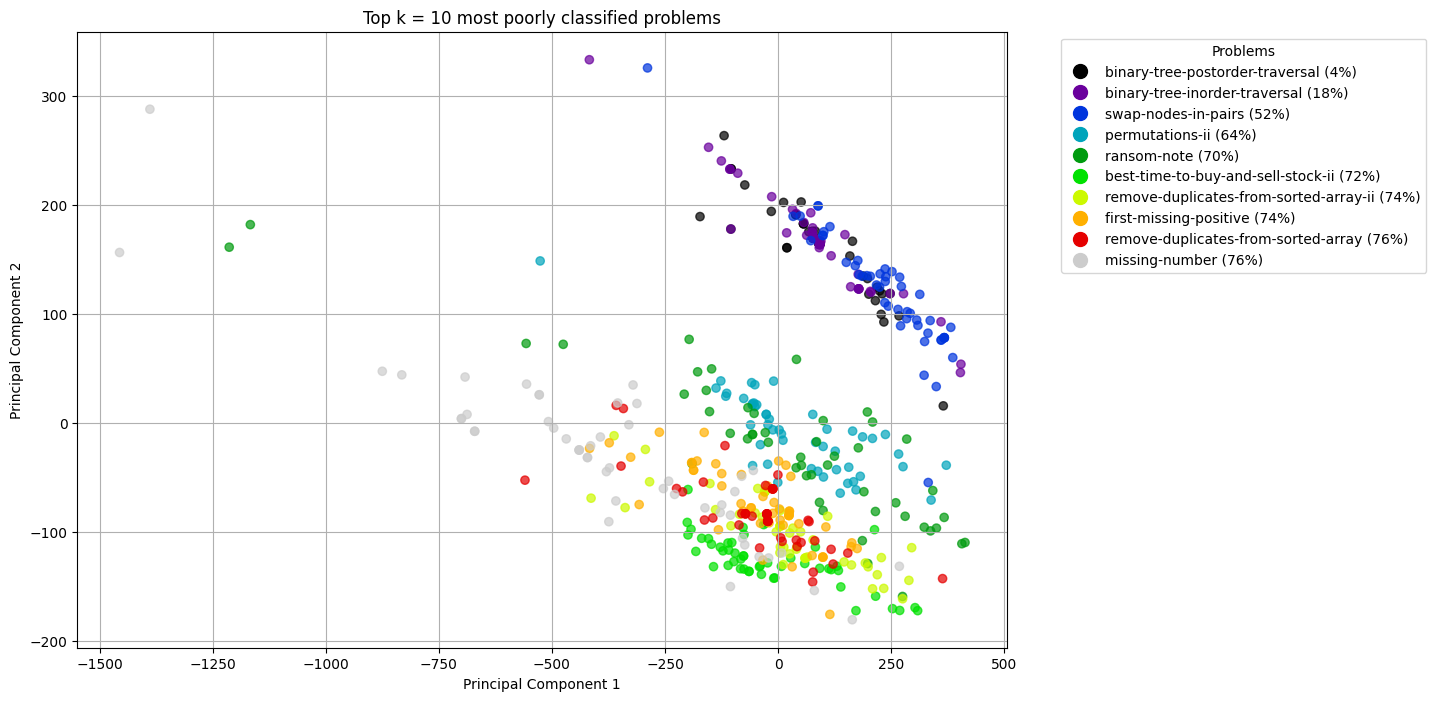

/tmp/ipykernel_6596/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


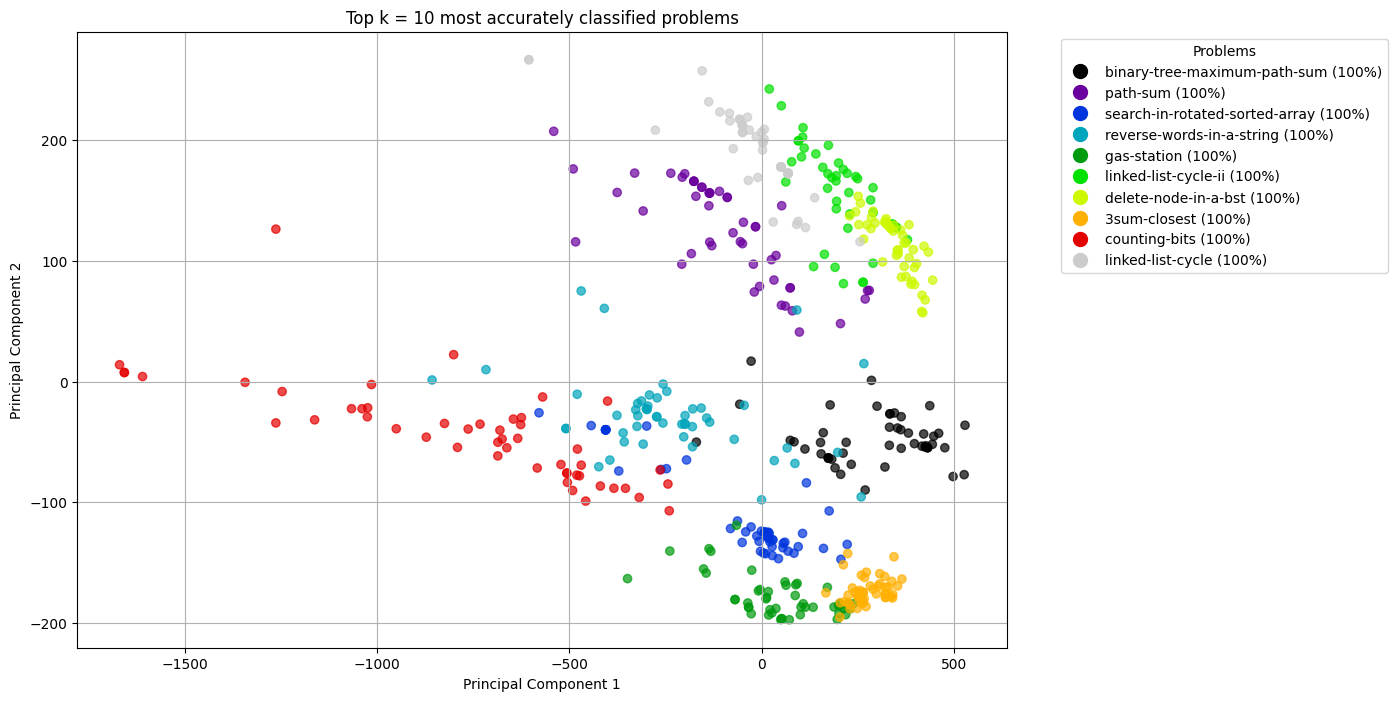

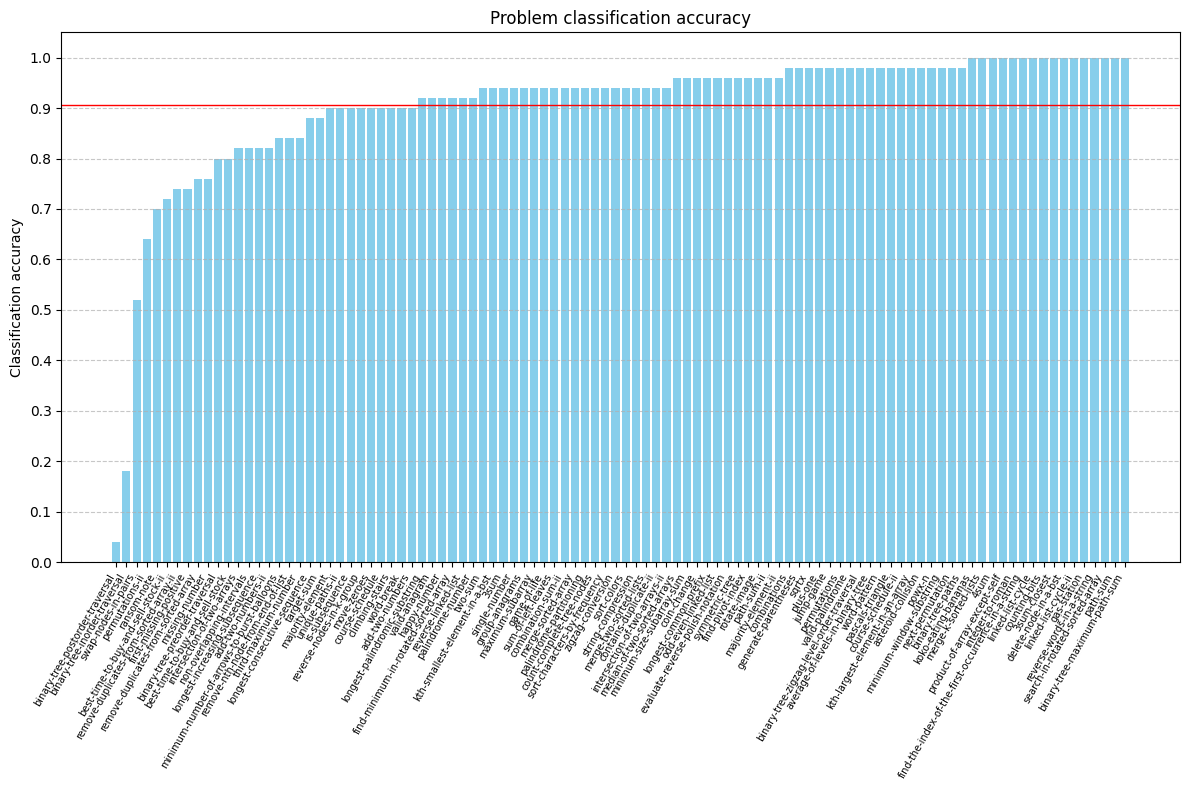

/tmp/ipykernel_6596/752781881.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("autumn")


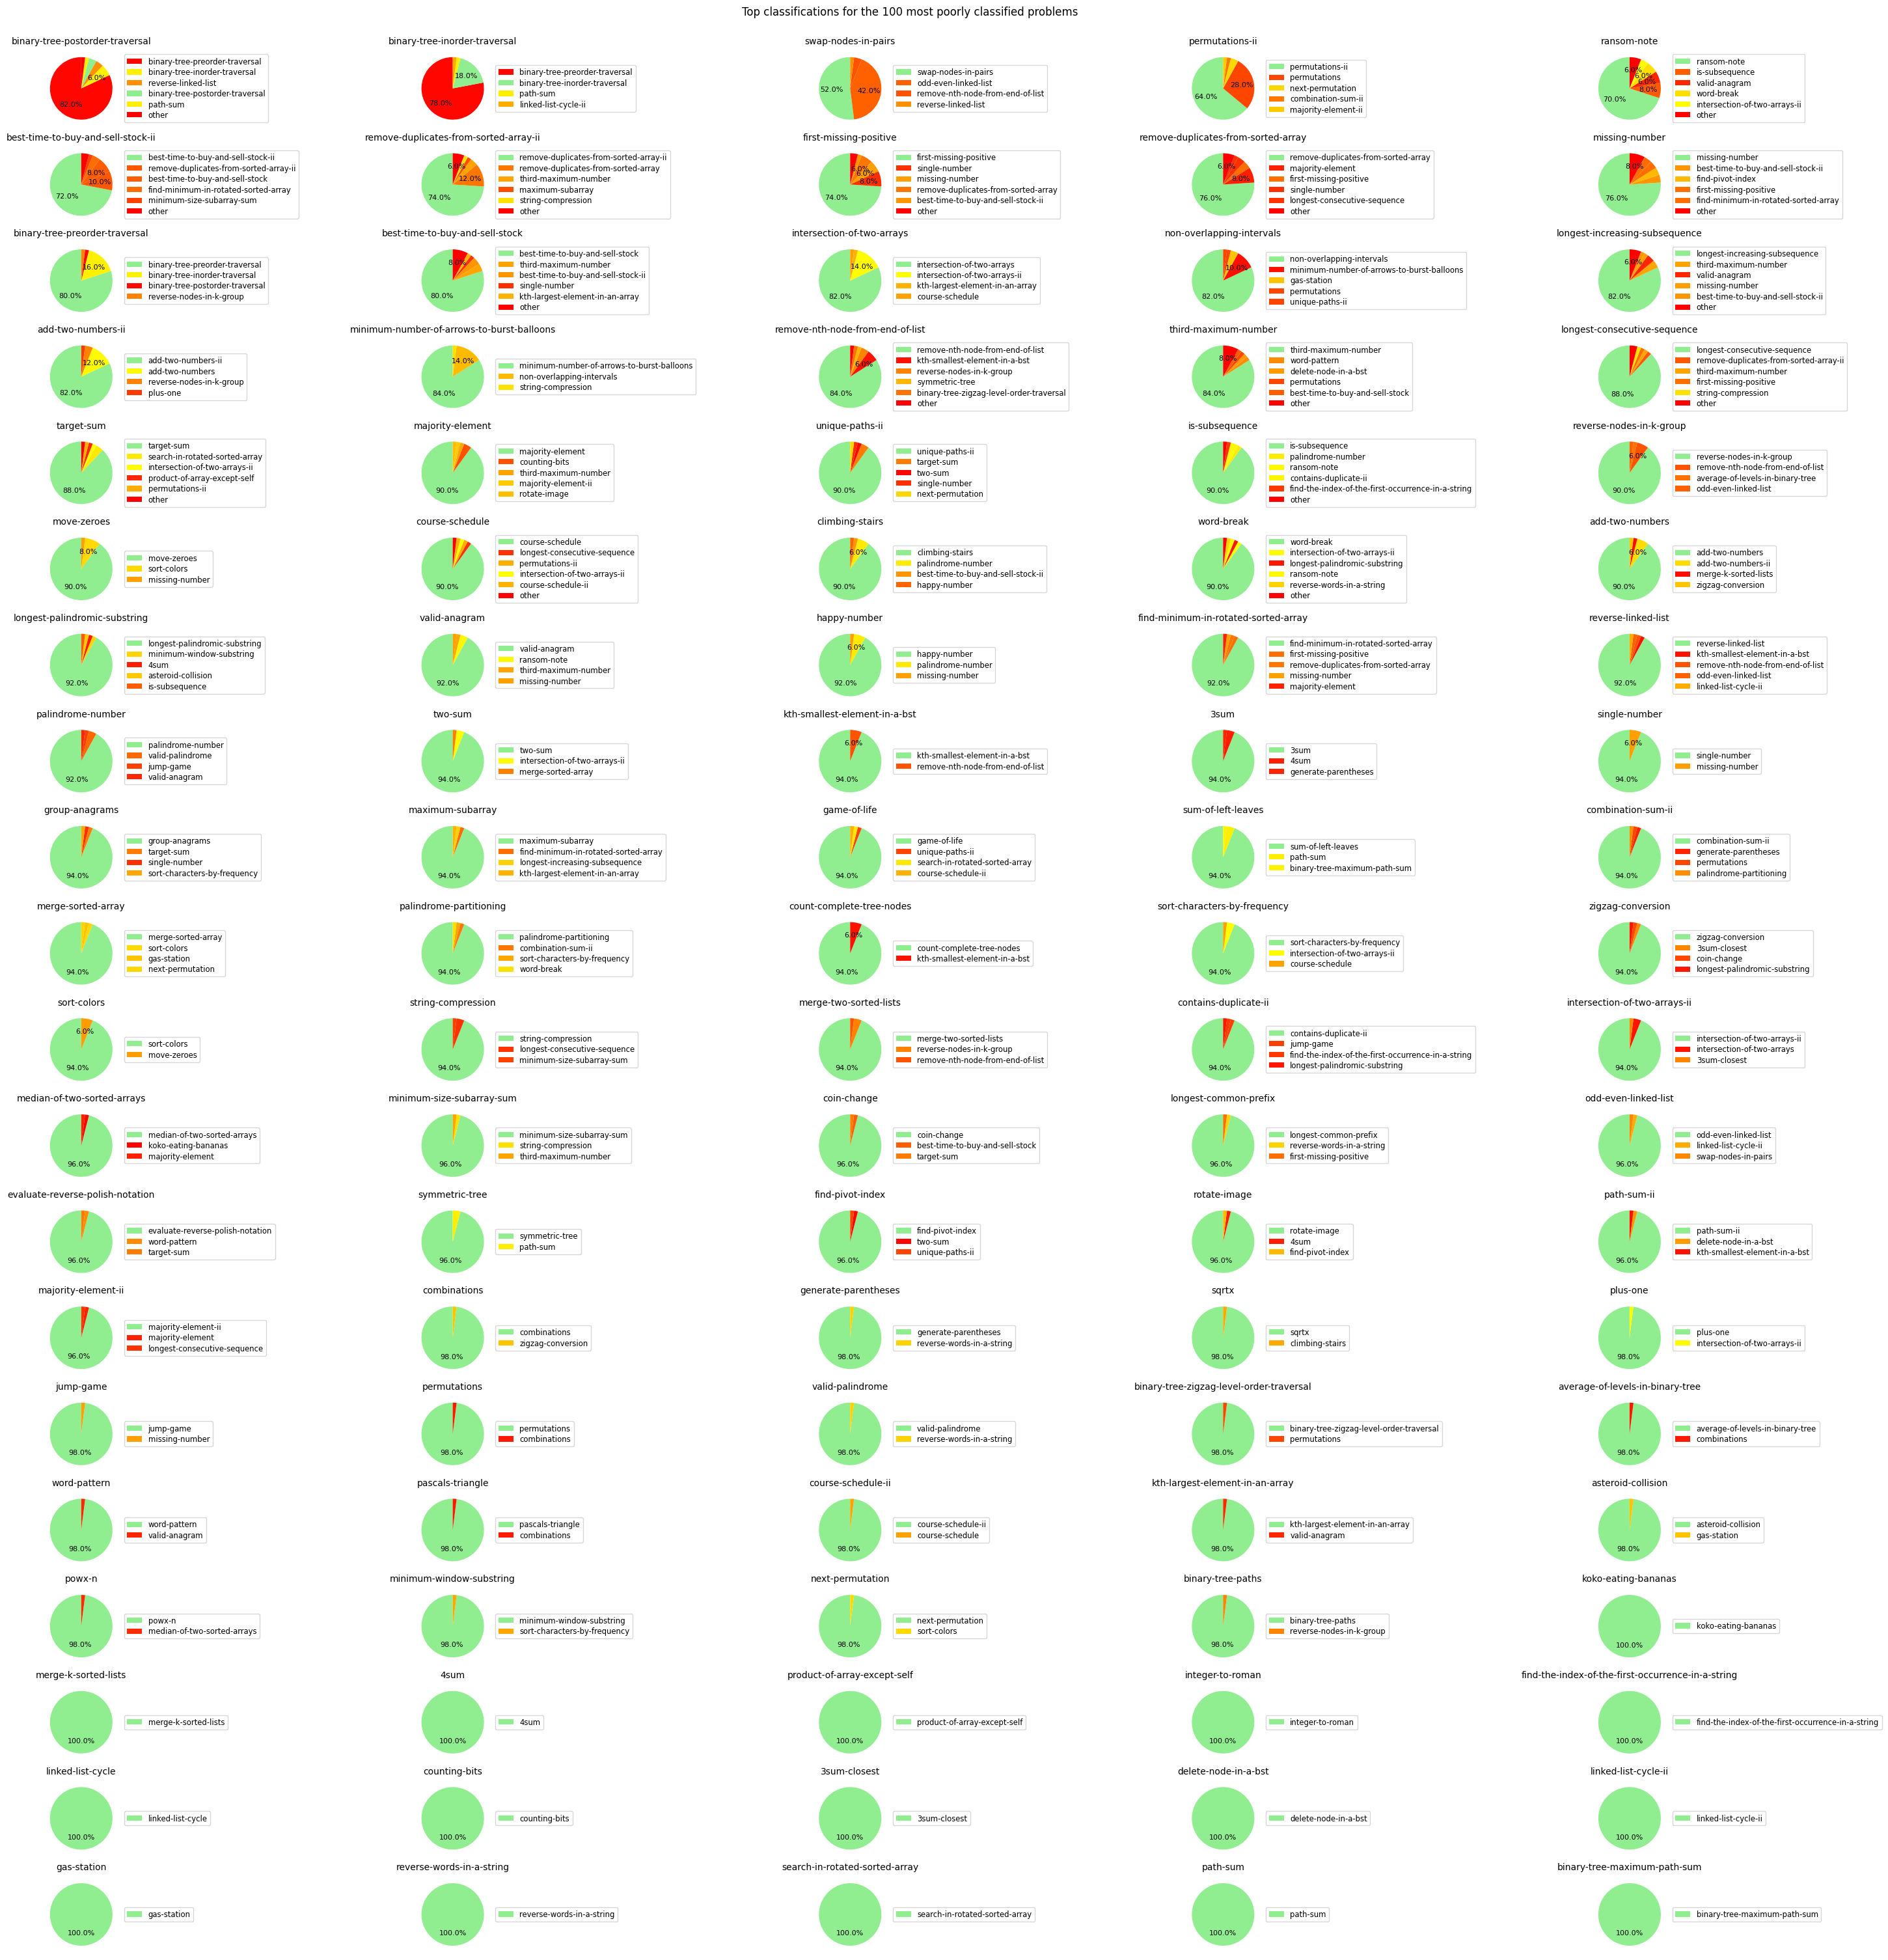

In [42]:
loaded_model.eval()  # Set model to evaluation mode

classes = {}
for i in range (NUM_CLASSES):
    classes[i] = (0, [])

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting Outputs"):
        batch = batch.to(device)
        out = model(batch.x, batch.batch)  # Shape: (batch_size, num_classes)
        max_idx = torch.argmax(out).item()
        actual_idx = torch.argmax(batch.y.float().reshape(1, NUM_CLASSES)).item()
        
        correct = 1 if max_idx == actual_idx else 0
        total_correct, class_outputs = classes[actual_idx]
        total_correct += correct
        class_outputs.append(out.cpu())
        classes[actual_idx] = (total_correct, class_outputs)

plot_classifications(classes, k=10)
plot_classifications(classes, k=10, best=True)
plot_problem_accuracies(classes)
plot_misclassifications(classes, n=100, k=5)